<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/train_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y wavefilter
!pip install "git+https://github.com/benkrikler/wavefilter@BK_debug-plotting#egg=wavefilter"

Found existing installation: wavefilter 0.0.1
Uninstalling wavefilter-0.0.1:
  Successfully uninstalled wavefilter-0.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter (to revision BK_debug-plotting) to /tmp/pip-install-p3iv7asp/wavefilter_bc272c35b7e245069791e61f5612d5de
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-p3iv7asp/wavefilter_bc272c35b7e245069791e61f5612d5de
  Running command git checkout -b BK_debug-plotting --track origin/BK_debug-plotting
  Switched to a new branch 'BK_debug-plotting'
  Branch 'BK_debug-plotting' set up to track remote branch 'BK_debug-plotting' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=10431 sha256=179087fb475aec84b60e600dee480b12f9a2e

In [2]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4149 sha256=5f120c94ea34dd063f39fb64fe00a838f0ba5e48a39360ac10893376cccf7742
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [3]:
import numpy as np
import pandas as pd
import logging
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder
from wavefilter.inspect import InspectActivations
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
wavefilter.evaluate.logging.basicConfig(level=logging.INFO)

Using cuda device


In [4]:
# from importlib import reload
# reload(wavefilter.inspect)
# reload(wavefilter)

## Make some data

In [5]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data

array([[-2.3894267 ,  0.4011284 ,  0.6805633 , ..., -0.7758019 ,
        -1.744965  ,  3.6780386 ],
       [-0.31556103,  1.8309597 , -0.67853296, ...,  2.1434069 ,
         3.167523  , -2.0875993 ],
       [-1.7256233 ,  1.3732045 , -1.8204856 , ...,  0.81800073,
         0.31299007,  1.02463   ],
       ...,
       [ 2.944832  ,  0.62899184, -1.1024506 , ..., -1.3631332 ,
         1.9348071 , -0.22485286],
       [-0.8018567 , -6.3191376 , -0.4756643 , ..., -1.2778208 ,
        -2.5279043 , -0.96978235],
       [ 0.27266732, -2.293285  , -2.0971816 , ..., 12.118013  ,
         9.95682   , 10.655377  ]], dtype=float32)

In [6]:
ds = wds.to_torch_dataset(data)
train_loader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f2aa82f6bf0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f2a2b5ff5f0>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f2a2b5fb5f0>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f2a2b6025f0>)]


## Set up the model

In [53]:
class Conv1dPulseFinderAttention_v4(models.Conv1dPulseFinderAttentionBase):
    def __init__(self, *args, **kwargs):
      super().__init__(*args, **kwargs)
      self.first_scale = torch.nn.Conv1d(1, 1, 5, padding="same")
    def forward(self, ampl: torch.Tensor, original: torch.Tensor):
        inputs = super().forward_step1(ampl, original)
        inputs = torch.roll(inputs, self.pf_length //2, -1)
       # scale = self.scale(inputs)
       # attend = torch.tanh(F.softshrink(scale))
       # return F.softmax(attend, -1)
        attend = F.leaky_relu(inputs)
        attend = self.first_scale(attend)
        attend = torch.sigmoid(attend)
        #attend = F.leaky_relu(inputs)
        attend = F.softmax(attend, -1)
        attend = torch.roll(attend, self.pf_length //2, -1)
        attend = self.scale(attend)
        return attend

attention = models.ParallelWeightedModules()
attention.add("conv_pulse_finder", Conv1dPulseFinderAttention_v4(50, False), 0)
attention.add("soft_max", models.GlobalSoftMaxAttention(), 1)

model = models.WaveFilter(200, attention).to(device)
#model = models.WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention_v4(
      (pulse_finder): Conv1d(1, 1, kernel_size=(50,), stride=(1,), padding=same)
      (combine): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
      (first_scale): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=same)
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


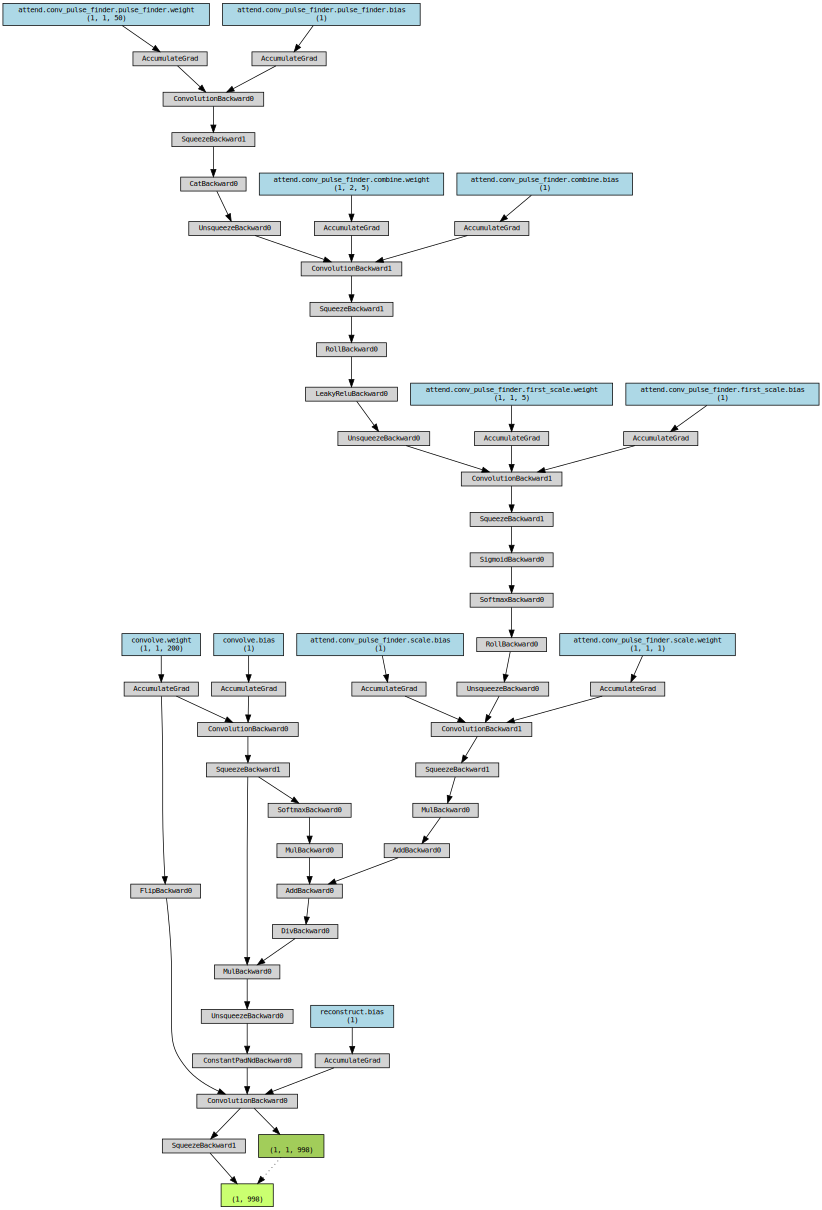

In [54]:
##    If a node represents a backward function, it is gray. Otherwise, the node
##   represents a tensor and is either blue, orange, or green:
##    - Blue: reachable leaf tensors that requires grad (tensors whose `.grad`
##        fields will be populated during `.backward()`)
##    - Orange: saved tensors of custom autograd functions as well as those
##        saved by built-in backward nodes
##    - Green: tensor passed in as outputs
##    - Dark green: if any output is a view, we represent its base tensor with
##        a dark green node.
make_dot(model(ds[0][0].to(device)), params=dict(list(model.named_parameters())))

## Train our model

In [55]:
params = split_parameters(model, ['attend'])
[[tuple(t.shape) for t in p["params"]] for p in params]

[[(1, 1, 50), (1,), (1, 2, 5), (1,), (1, 1, 1), (1,), (1, 1, 5), (1,)],
 [(1, 1, 200), (1,), (1,)]]

In [56]:
lr_schedules = [lambda x: 0.99, lambda x: 0.95**x]
tester = train_parallel_pulse_finder(train_loader, model, param_groups=params,
                                     lr_schedules=lr_schedules, device=device,
                                     epochs=300,
                                     start_incrementing = 20,
                                     epochs_per_increment = 40,
                                     change_per_increment = 0.20,
)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

## Inspect what we've learnt

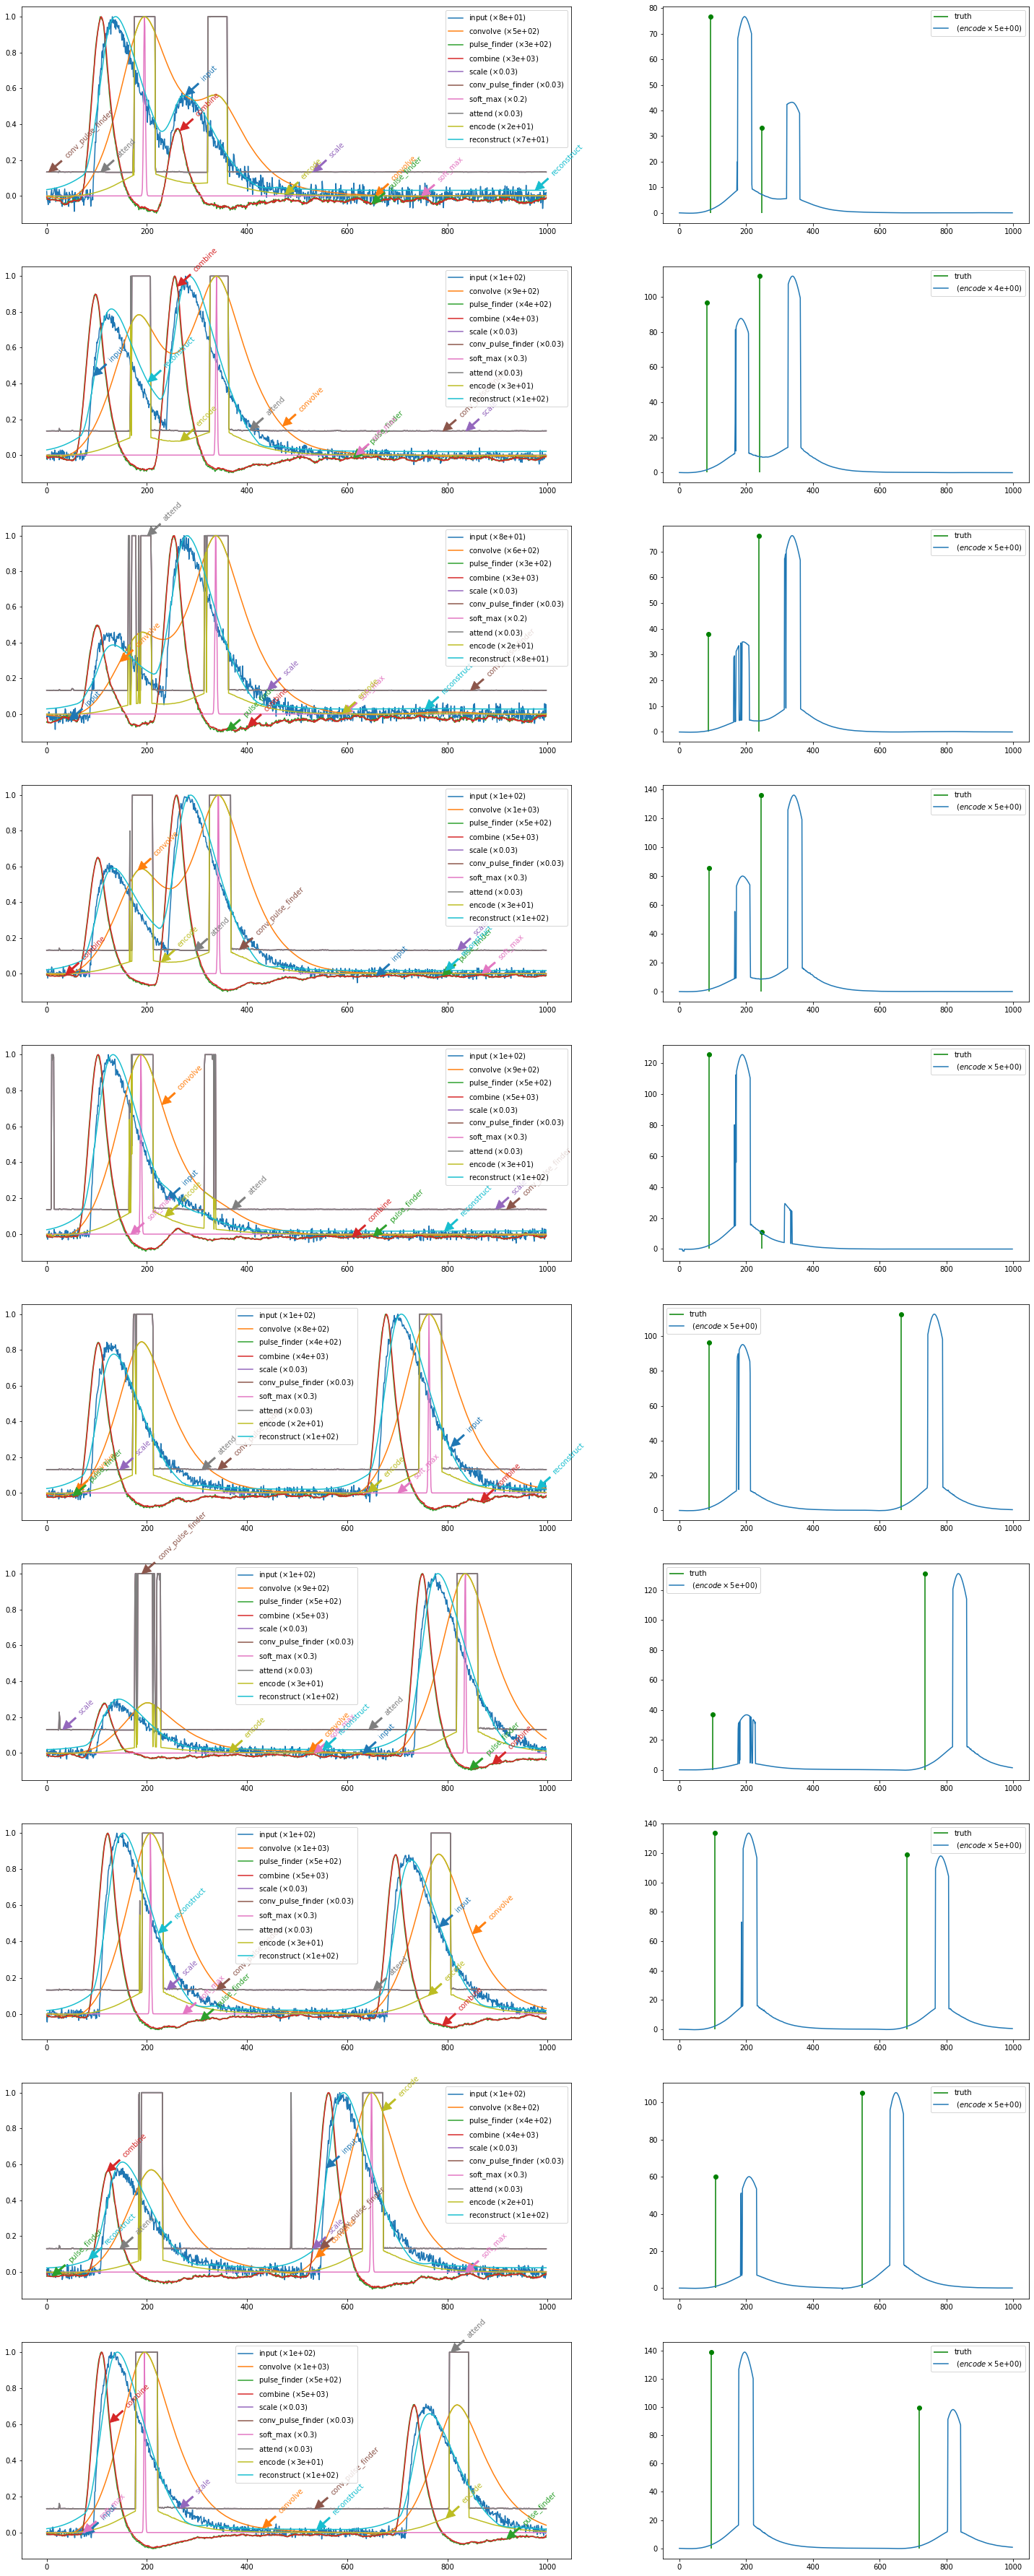

In [57]:
activations = InspectActivations(device)
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
activations.inspect(model, ds, true_amp=truth[0], true_time=truth[1], indices=choices, compare_truth="encode")

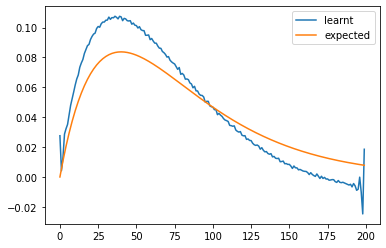

In [58]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

1.2800053

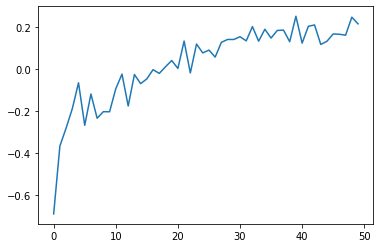

In [59]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
learnt.sum()

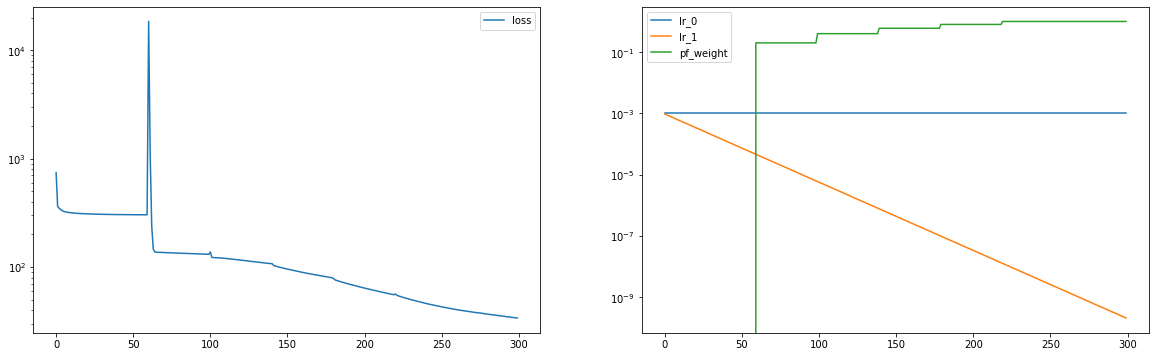

In [60]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(tester.train["loss"], label="loss");
ax[0].legend()
ax[0].set_yscale("log")
for name in ["lr_0", "lr_1", "pf_weight"]:
    ax[1].plot(tester.train[name], label=name);
ax[1].set_yscale("log")
ax[1].legend()

In [61]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[ 0.0276,  0.0042,  0.0132,  0.0287,  0.0323,  0.0352,  0.0418,
           0.0479,  0.0523,  0.0569,  0.0616,  0.0656,  0.0683,  0.0735,
           0.0763,  0.0786,  0.0827,  0.0852,  0.0879,  0.0887,  0.0920,
           0.0941,  0.0956,  0.0963,  0.0994,  0.1007,  0.1002,  0.1026,
           0.1037,  0.1037,  0.1049,  0.1050,  0.1070,  0.1055,  0.1067,
           0.1065,  0.1076,  0.1069,  0.1058,  0.1076,  0.1072,  0.1047,
           0.1062,  0.1058,  0.1046,  0.1044,  0.1046,  0.1023,  0.1030,
           0.1016,  0.1013,  0.0997,  0.1006,  0.0986,  0.0980,  0.0979,
           0.0949,  0.0949,  0.0951,  0.0919,  0.0927,  0.0910,  0.0896,
           0.0896,  0.0877,  0.0862,  0.0861,  0.0840,  0.0832,  0.0821,
           0.0803,  0.0806,  0.0782,  0.0771,  0.0763,  0.0756,  0.0739,
           0.0720,  0.0733,  0.0687,  0.0693,  0.0683,  0.0655,  0.0656,
           0.0651,  0.0629,  0.0623,  0.0597,  0.0607,  0.0576,  0.0576,
           

In [62]:
model.attend.module_weights

{'conv_pulse_finder': 1.0, 'soft_max': -5.551115123125783e-17}